In [1]:
import pandas as pd               
import numpy as np
import math

In [2]:
import spiceypy as sp
import astropy.coordinates
import re
import sgp4.api as sg
import astropy.units as u
from astropy.coordinates import SkyCoord

In [3]:
import matplotlib.pyplot as plt
import os
import sys
from timeit import default_timer as timer
from astropy.time import Time
from astropy.time import TimeDelta
import datetime as dt

#### Let us start with reading in the first 10000 LSST observations for Main Belt Asteroids (S1 in the Synthetic Solar System model)

In [4]:
path = "/data/projects/lsst/baseline_fbs_v1p7p1/"
dir_list = os.listdir(path)

dflist=[]

for d in dir_list:
    if(d[0:2]=='S1'):
        dflist.append(pd.read_hdf('/data/projects/lsst/baseline_fbs_v1p7p1/'+d+'/visit-0000000.h5'))
        dflist.append(pd.read_hdf('/data/projects/lsst/baseline_fbs_v1p7p1/'+d+'/visit-0010000.h5'))

In [5]:
# every dataframe looks like this
dflist[0]

,ObjID,FieldID,FieldMJD,AstRange(km),AstRangeRate(km/s),AstRA(deg),AstRARate(deg/day),AstDec(deg),AstDecRate(deg/day),Ast-Sun(J2000x)(km),...,MaginFilterTrue,AstrometricSigma(mas),PhotometricSigma(mag),SNR,AstrometricSigma(deg),MaginFilter,dmagDetect,AstRATrue(deg),AstDecTrue(deg),filter
211,S1005COHa,8587,59865.021493,2.690753e+08,13.782810,340.818744,-0.095850,-7.472619,-0.013669,3.928341e+08,...,19.468831,10.696579,0.005886,183.966858,0.000003,19.465719,0.003215,340.818741,-7.472622,r
546,S1005CXma,5510,59861.138563,4.454802e+08,18.662921,327.614280,-0.045996,-17.407163,0.017972,5.029721e+08,...,22.467690,90.460293,0.180959,5.513790,0.000025,22.383414,0.001497,327.614256,-17.407186,z
1203,S1005DbNa,3421,59858.266303,2.911199e+08,-2.884087,29.040982,-0.170618,-0.066137,-0.124001,4.004475e+08,...,22.321059,112.979378,0.219621,4.460532,0.000031,22.105486,0.028190,29.040965,-0.066202,y
1299,S1005Ddta,9138,59865.290202,2.112398e+08,-1.127916,31.217419,-0.259774,5.339466,-0.071889,3.204824e+08,...,19.024007,12.785436,0.016855,63.918065,0.000004,19.053602,0.043812,31.217421,5.339464,y
2116,S1005Dyza,8654,59865.054790,3.644915e+08,21.046205,319.284823,0.027663,-7.971674,-0.009323,4.144269e+08,...,22.678947,27.121781,0.042784,24.880463,0.000008,22.704115,0.000359,319.284810,-7.971661,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476169,S1005khoa,2362,59857.171250,3.165510e+08,10.602041,345.841875,-0.170822,-8.606697,-0.007663,4.500491e+08,...,20.367995,24.692837,0.044988,23.637483,0.000007,20.374396,0.016343,345.841879,-8.606696,y
1476657,S1005kpIa,7151,59863.120770,4.141916e+08,24.719844,319.797276,0.021937,-31.362545,0.075049,4.126039e+08,...,21.724321,35.525918,0.065486,16.084679,0.000010,21.881854,0.003293,319.797278,-31.362536,i
1476660,S1005kpIa,7184,59863.137163,4.142266e+08,24.751666,319.797651,0.022363,-31.361289,0.075284,4.126185e+08,...,21.717580,35.489650,0.074790,14.022869,0.000010,21.718822,0.004291,319.797641,-31.361304,z
1476940,S1005kwia,7710,59863.992235,4.046265e+08,23.371508,311.638323,0.069374,-8.463460,-0.083847,4.076687e+08,...,22.609969,88.901803,0.104647,9.883230,0.000025,22.698784,0.002677,311.638298,-8.463429,r


In [6]:
# concatenate them into a single dataframe
dfin=pd.concat(dflist)

In [7]:
# we can sort the resulting dataframe by by FieldID
dfin.sort_values(['FieldID'], inplace=True)

In [8]:
# then grouping and counting is a little faster. It seems that FieldID 0 has the most observations
dfin.groupby(['FieldID']).count()['ObjID']

FieldID
0        390
1        363
2        164
3         96
4         77
        ... 
19992      3
19993      1
19996      2
19998      3
19999      1
Name: ObjID, Length: 16608, dtype: int64

In [9]:
def icrf2radec(pos, deg=True):
    """Convert ICRF xyz to Right Ascension and Declination.
    Geometric states on unit sphere, no light travel time/aberration correction.
    
    Parameters:
    -----------
    pos ... real, dim=[n, 3], 3D vector of unit length (ICRF)
    deg ... True: angles in degrees, False: angles in radians
    Returns:
    --------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    """
    norm=np.linalg.norm
    array=np.array
    arctan2=np.arctan2
    arcsin=np.arcsin
    rad2deg=np.rad2deg
    modulo=np.mod
    pix2=2.*np.pi
    
    if(pos.ndim>1):
        r=norm(pos,axis=1)
        xu=pos[:,0]/r
        yu=pos[:,1]/r
        zu=pos[:,2]/r
    else:
        r=norm(pos)
        xu=pos[0]/r
        yu=pos[1]/r
        zu=pos[2]/r
    
    phi=arctan2(yu,xu)
    delta=arcsin(zu)
    
    if(deg):
        ra = modulo(rad2deg(phi)+360,360)
        dec = rad2deg(delta)
    else:
        ra = modulo(phi+pix2,pix2)
        dec = delta
    
    return ra, dec

In [10]:
def radec2icrf(ra, dec, deg=True):
    """Convert Right Ascension and Declination to ICRF xyz unit vector.
    Geometric states on unit sphere, no light travel time/aberration correction.
    
    Parameters:
    -----------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    deg ... True: angles in degrees, False: angles in radians
    Returns:
    --------
    x,y,z ... 3D vector of unit length (ICRF)
    """
    deg2rad=np.deg2rad
    array=np.array
    cos=np.cos
    sin=np.sin
    
    if(deg):
        a = deg2rad(ra)
        d = deg2rad(dec)
    else:
        a = array(ra)
        d = array(dec)
    
    cosd = cos(d)
    x = cosd*cos(a)
    y = cosd*sin(a)
    z = sin(d)
    
    return array([x, y, z])

In [11]:
field_ids = dfin['FieldID'].unique()

In [12]:
dates = dfin['FieldMJD'].unique()

In [13]:
print("Earliest field date: " + str(min(dates)) + " or 10-01-2022 at 23:39:19.663 UTC")
print("Last field date: " + str(max(dates)) + " or 10-30-2022 at 05:03:20.104 UTC")

Earliest field date: 59853.98564424414 or 10-01-2022 at 23:39:19.663 UTC
Last field date: 59882.21064935192 or 10-30-2022 at 05:03:20.104 UTC


In [14]:
# open the TLE files
with open('starlink tle.txt') as f:
    starlinks = f.read().splitlines() 

In [15]:
# split up the list into 3-line lists for each satellite
chunks = [starlinks[n:n + 3] for n in range(0, len(starlinks), 3)]

In [17]:
print("There are " + str(len(chunks)) + " satellites")

There are 1653 satellites


In [18]:
import warnings

In [19]:
def bearing(lat1, long1, lat2, long2):
    '''
    Finds the bearing from one (latitude, longitude) point to another
    
    Parameters:
    -----------
    lat1, long1 ... real [rad]: Initial point
    lat2, long2 ... real [rad]: End point
    
    Returns:
    --------
    bear ... real [rad]: Bearing    
    '''
    
    b2 = np.sin(long2-long1) * np.cos(lat2)
    b1 = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(long2-long1)
    bear = np.arctan2(b2, b1)
    
    return bear
    
    
def cross_track_distance(lat1, long1, lat2, long2, lat3, long3):
    '''
    Finds the cross track distance from a point to line
    
    Parameters:
    -----------
    lat1, long1 ... real [rad]: Initial point of line
    lat2, long2 ... real [rad]: End point of line
    lat3, long3 ... real [rad]: Third point
    
    Returns:
    --------
    dist ... real [rad]: Cross track distance 
    '''
    c1 = SkyCoord(ra=long1*u.radian, dec=lat1*u.radian, frame='icrs')  # First point
    c2 = SkyCoord(ra=long3*u.radian, dec=lat3*u.radian, frame='icrs')  # Third point

    sep = c1.separation(c2)
    
    bear_1_3 = bearing(lat1, long1, lat3, long3)
    bear_1_2 = bearing(lat1, long1, lat2, long2)

    dist = np.arcsin(np.sin(sep.radian) * np.sin((bear_1_3) - bear_1_2))
    
    return dist

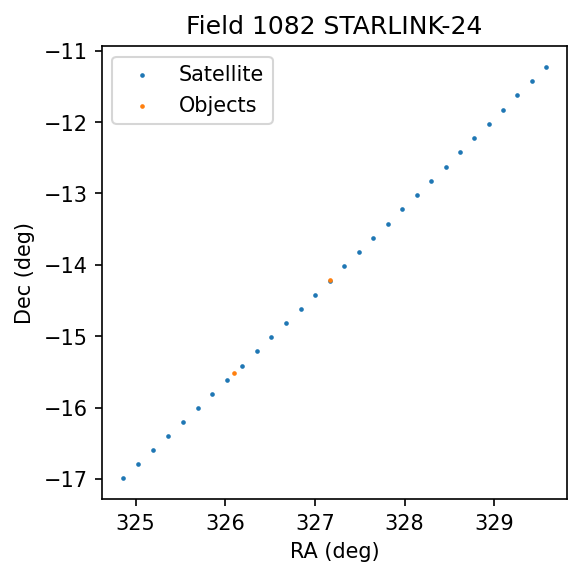

Number of objects affected: 2

Satellite times:
[59855.088124053495, 59855.08814720164, 59855.088170349794, 59855.08819349794, 59855.08821664609, 59855.08823979423, 59855.08826294239, 59855.08828609053, 59855.08830923868, 59855.088332386826, 59855.08835553498, 59855.088378683125, 59855.08840183127, 59855.08842497942, 59855.08844812757, 59855.08847127572, 59855.088494423864, 59855.08851757201, 59855.088540720164, 59855.08856386831, 59855.08858701646, 59855.0886101646, 59855.08863331276, 59855.0886564609, 59855.08867960905, 59855.088702757195, 59855.08872590535, 59855.088749053495, 59855.08877220164, 59855.08879534979]


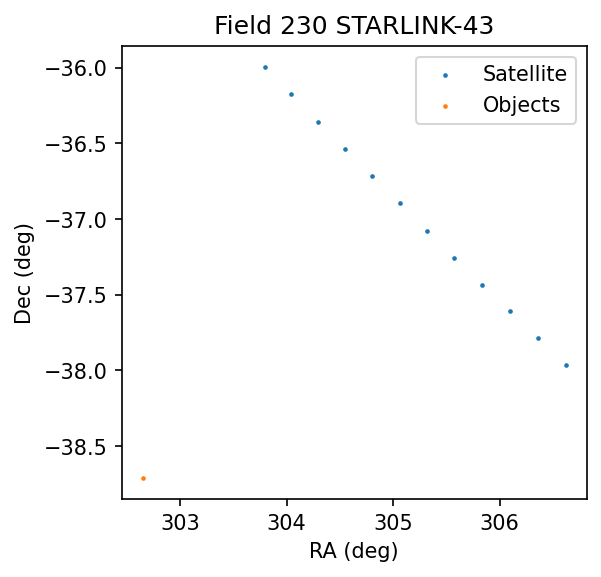

Number of objects affected: 1

Satellite times:
[59854.09194752264, 59854.09197067079, 59854.09199381893, 59854.092016967086, 59854.09204011523, 59854.09206326338, 59854.092086411525, 59854.09210955968, 59854.092132707825, 59854.09215585597, 59854.09217900412, 59854.09220215227]

Could not propagate STARLINK-70


Could not propagate STARLINK-76



In [24]:
# Time calculations output warnings --> ignore them
warnings.filterwarnings('ignore')

# first iterate through each satellite
for ch in chunks[:7]:
    sat_num = ch[0].strip()  # the label for each satellite --> STARLINK-xx
    s = ch[1]  # first line of TLE set
    t = ch[2]  # second line of TLE set
    sat = sg.Satrec.twoline2rv(s, t)  
    
    flag_2 = False

    # if True, satellite can't be propagated, so continue to next satellite
    if flag_2:
        continue
    
    # check each satellite against each field
    for f in field_ids[100:1000]:
        ra_vals = []  # for satellites' right ascensions
        dec_vals = []  # for satellites' declinations
        sat_times = []  # for satellites' times
        
        data = dfin[dfin['FieldID']==f]  # all objects in the field

        ra_f = data['AstRA(deg)']  # RA of all objects
        dec_f = data['AstDec(deg)']  # Dec of all objects
                
        min_ra, max_ra = min(ra_f), max(ra_f)
        min_dec, max_dec = min(dec_f), max(dec_f)

        mjd_t = data['FieldMJD'].unique()[0]  # field time
        
        t = Time(mjd_t, format='mjd')  # convert to Time format
        t_change = TimeDelta(2.0, format='sec')
        
        flag = False
        
        count = 1
        
        # Start 30 seconds before field time
        t_before = t - TimeDelta(30.0, format='sec')
        
        # We're going to propagate every 2 seconds from 30 seconds before to 30 seconds after field time because exposure for the field is 30 seconds
        # Because of this, there will be 61 total iterations of propagations
        # If a satellite is within this time, it will leave a streak in the field image
        while count <= 61:
            jd_t = t_before + 2400000.5  # convert MJD to JD for sgp4 propagation calculation
            fr, whole = math.modf(float(str(jd_t)))  # fr = digits after decimal of MJD
    
            e, r, v = sat.sgp4(float(str(jd_t)), round(fr, 12))  # r is [x,y,z] for propagated satellite
            x, y, z = r[0], r[1], r[2]
            length = np.sqrt(x**2 + y**2 + z**2)
            norm_coords = np.array([x/length, y/length, z/length])  # normalizing onto unit sphere
            ra, dec = icrf2radec(norm_coords)  # convert to RA and Dec
            
            if ra != ra:  # if nan --> satellite can't be propagated to that time
                flag = True
                break  # don't bother looking at all the times --> break while loop

            # if the object is in the field i.e. within 1 degree
            if (min_ra - 1.0 <= ra <= max_ra + 1.0) and (min_dec - 1.0 <= dec <= max_dec + 1.0):
                ra_vals.append(ra)
                dec_vals.append(dec)
                sat_times.append(t_before.value)
    
            t_before += t_change  # Propagate 2.0 seconds
            count += 1 
            
        if flag:
            print()
            print("Could not propagate " + sat_num)
            print()
            flag_2 = True
            break  # break out of for loop of the fields
                
        # Only satellite points that are within the field of objects
        if any(ra_vals):
            good_obj_ra, good_obj_dec = [], []
            
            obj_count = 0
            
            # for satellites
            min_ra, max_ra = min(ra_vals), max(ra_vals)
            min_dec, max_dec = min(dec_vals), max(dec_vals)
            
            min_long, max_long = np.deg2rad(min_ra), np.deg2rad(max_ra)
        
            min_lat, max_lat = np.deg2rad(min_dec), np.deg2rad(max_dec)        

            for obj_r, obj_d in zip(ra_f, dec_f):
                obj_long = np.deg2rad(obj_r)
                obj_lat = np.deg2rad(obj_d)

                bound_d = 2.0 * np.pi/(180*3600)  # 2 arcseconds in radians

                # calculate cross track distance between satellite streak and objects
                dist = cross_track_distance(min_lat, min_long, max_lat, max_long, obj_lat, obj_long)
                
                # an object is considered obstructed if the satellite streak is within 2 arcseconds of it
                if abs(dist) <= bound_d:
                    good_obj_ra.append(obj_r)
                    good_obj_dec.append(obj_d)
                    obj_count += 1
                    
            # only plot objects that are obstructed 
            if any(good_obj_ra):
                plt.figure(dpi=150,figsize=(4,4))
                plt.scatter(ra_vals, dec_vals, s=1.5, label='Satellite')
                plt.scatter(good_obj_ra, good_obj_dec, s=1.5, label='Objects')
                title = "Field " + str(f) + " " + sat_num
                plt.title(title)
                plt.xlabel('RA (deg)')
                plt.ylabel('Dec (deg)')
                plt.legend()
#                 plt.savefig(title)
                plt.show()

                print("Number of objects affected: " + str(obj_count))
                print()
                print("Satellite times:")
                print(str(sat_times))

### As seen in plot "Field 230 STARLINK-43", an object is being categorized as affected, even though visually it looks much farther away from the satellite streak than 2 arcseconds. This probable error is repeated several times throughout the execution of the code. It is not yet known if this is indeed an error in calculation, or in fact those objects are 2 arcseconds away from the satellite streak.